#### This Notebook is a duplicate of basin_spatial_dependence but for troubleshooting
I am currently trying to figure out why dependence = independence on a smaller subset of basins

#### The notebook is structured as following
1. Download river flow data for thailand
2. Perform Data Checks
3. Extract discharge timeseries at basin outlet points
4. Fit Extreme Value Distribution (Gumbel)
5. Transform data to Uniform Marginals
6. Calculate pairwise dependence using the inverse Clayton copula

### 1. Download river flow data for Thailand

In [1]:
# Import Necessary Functions
import os
import xarray as xr
import netCDF4
# CDS API
import cdsapi
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()
# Disable xarray runtime warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

In [2]:
# Set up CDS API key

if os.path.isfile("C:/Users/Mark.DESKTOP-UFHIN6T/.cdsapirc"):
    cdsapi_kwargs = {}
else:
    URL = 'https://cds.climate.copernicus.eu/api/v2'
    KEY = '##################################'
    cdsapi_kwargs = {
        'url': URL,
        'key': KEY,
    }

In [3]:
# Set up data directory
DATADIR = r"D:\projects\sovereign-risk\Thailand\data\flood\dependence\glofas"
os.makedirs(DATADIR, exist_ok=True)

In [4]:
# Download data for Thaiand (the GIRI model uses the historical time period 1979-2016). We will pull data from 1979-2023
start_year = 1979
end_year = 2023
# new_dir = os.path.join(DATADIR, f"THA_{start_year}-{end_year}")
# os.makedirs(new_dir)
c = cdsapi.Client(
    **cdsapi_kwargs
    )
for year in range(start_year, end_year+1):
    download_file = f"{DATADIR}/glofas_THA_{year}.grib"
    if not os.path.isfile(download_file):
        request_params = {
            'system_version': 'version_4_0',
            'hydrological_model': 'lisflood',
            'product_type': 'consolidated',
            'variable': 'river_discharge_in_the_last_24_hours',
            'hyear': [f"{year}"],
            'hmonth': ['january', 'february', 'march', 'april', 'may', 'june', 
                       'july', 'august', 'september', 'october', 'november', 'december'],
            'hday': [f"{day:02d}" for day in range(1,31)],
            'format': 'grib',
            'area': [21, 97, 5, 106], # slightly larger bounding box than Thailand
        }
        c.retrieve('cems-glofas-historical', request_params).download(download_file)

In [5]:
# Download the upstream area
# NOTE: issue downloading a valid netcdf in current script. Workaround at the moment is using file I've previously downloaded
upstream_area_fname = f"uparea_glofas_v4_0.nc"
upstream_area_file = os.path.join(DATADIR, upstream_area_fname)
# If we have not already downloaded the data, download it.
if not os.path.isfile(upstream_area_file):
    u_version=2 # file version
    upstream_data_url = (
        f"https://confluence.ecmwf.int/download/attachments/242067380/{upstream_area_file}?"
        f"version{u_version}&modificationDate=1668604690076&api=v2&download=true"
    )
    import requests
    result = requests.get(upstream_data_url)
    with open(upstream_area_file, 'wb') as f:
        f.write(result.content)

In [6]:
def combine_datasets(start, end, dir):
    '''
    combine all datasets into one xarray for analysis
    '''
    all_files = [os.path.join(dir, f"glofas_THA_{year}.grib") for year in range(start, end+1)]
    # Load all datasets into array
    datasets = [xr.open_dataset(file, engine='cfgrib') for file in all_files]
    # Concatenate all datasets along the time dimension
    combined_dataset = xr.concat(datasets, dim='time')
    # Make sure datasets are sorted by time
    combined_dataset = combined_dataset.sortby('time')
    
    return combined_dataset

In [7]:
# Load glofas data and combine
glofas_data = combine_datasets(start_year, end_year, DATADIR)
# glofas_data

In [8]:
# Reduce the Upstream area data to the domain of the river discharge

# Filter glofas timeseries based on upstream accumulating area
area_filter = 500

# Open the file and print the contents
upstream_area = xr.open_dataset(upstream_area_file, engine='netcdf4')

# Get the latitude and longitude limits of the data
lat_limits = [glofas_data.latitude.values[i] for i in [0, -1]]
lon_limits = [glofas_data.longitude.values[i] for i in [0, -1]]
up_lats = upstream_area.latitude.values.tolist()
up_lons = upstream_area.longitude.values.tolist()

lat_slice_index = [
    round((i-up_lats[0])/(up_lats[1]-up_lats[0]))
    for i in lat_limits
]
lon_slice_index = [
    round((i-up_lons[0])/(up_lons[1]-up_lons[0]))
    for i in lon_limits
]

# Slice upstream area to Thailand region:
red_upstream_area = upstream_area.isel(
    latitude=slice(lat_slice_index[0], lat_slice_index[1]+1),
    longitude=slice(lon_slice_index[0], lon_slice_index[1]+1),
)

# There are very minor rounding differences, so we update with the lat/lons from the glofas data
red_upstream_area = red_upstream_area.assign_coords({
    'latitude': glofas_data.latitude,
    'longitude': glofas_data.longitude,
})

# Add the upstream area to the main data object and print the updated glofas data object:
glofas_data['uparea'] = red_upstream_area['uparea']
glofas_data

# Mask the river discharge data
glofas_data_masked = glofas_data.where(glofas_data.uparea>=area_filter*1e6)

In [9]:
# glofas_data_masked

### 2. Perform data checks

In [10]:
# import necessary libraries
import pandas as pd
import numpy as np

In [11]:
# Load the basin outlet data
basin_outlet_file = r"D:\projects\sovereign-risk\Thailand\data\flood\dependence\thailand-basins\test\trouble_shoot\lev06_outlets_TEST_6.csv"
basin_outlet_df = pd.read_csv(basin_outlet_file)
# Note to align the two datasets we need to make the following adjustment to lat lons (based on previous trial and error)
basin_outlet_df['Latitude'] = basin_outlet_df['Latitude'] + 0.05/2
basin_outlet_df['Longitude'] = basin_outlet_df['Longitude'] - 0.05/2

In [12]:
# Define function for checking timeseries
def check_timeseries(array, latitude, longitude):
    test_point = array.sel(latitude=latitude, longitude=longitude, method='nearest')
    test_timeseries = test_point['dis24']
    test_acc = float(test_point['uparea'])
    # check for NaN values
    non_nan_count = test_timeseries.count().item()
    total_count = test_timeseries.size
    nan_ratio = non_nan_count/total_count

    # Does the timeseries pass the NaN threshold
    if nan_ratio < 1:
        return False, test_acc, "NaN values found"

    # Check for constant values
    if test_timeseries.min() == test_timeseries.max():
        return False, test_acc, "Constant timeseries values"

    # If all checks pass
    return True, test_acc, "Valid timeseries"

In [13]:
# Loop through basins and check whether timeseries is valid
results = []
for index, row in basin_outlet_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']

    valid, acc, message = check_timeseries(glofas_data_masked, latitude, longitude)

    # Store the results
    results.append({
        'HYBAS_ID': row['HYBAS_ID'],
        'Latitude': latitude,
        'Longitude': longitude,
        'Acc': acc,
        'Valid': valid,
        'Message': message
    })
    if not valid:
        print(f"ID: {row['HYBAS_ID']}, Lat: {latitude}, Lon: {longitude}, Acc: {acc}, Valid: {valid}, Message: {message}")

### 3. Extract discharge timeseries at basin outlet points

In [14]:
# over what years do we want to extract the data?
start_year = 1979
end_year = 2016
sliced_data = glofas_data_masked.sel(time=slice(str(start_year), str(end_year)))
# Dictionary to store timeseries data for each basin
basin_timeseries = {}

# Loop through basin outlets, storing each in turn
for index, row in basin_outlet_df.iterrows():
    basin_id = row['HYBAS_ID']
    lat = row['Latitude']
    lon = row['Longitude']
    point_data = sliced_data.sel(latitude=lat, longitude=lon, method='nearest')
    timeseries = point_data['dis24'].to_series()
    # store in dictionary
    basin_timeseries[basin_id] = timeseries

### Step 4: Fit Extreme Value Distribution (Gumbel)

In [15]:
# Import necessary libraries
from lmoments3 import distr
from scipy.stats import gumbel_r, kstest

In [16]:
# Dictionary to store fitted parameters for each basin
gumbel_params = {}
fit_quality = {}

# Loop through basins, calculating annual maxima and fitting Gumbel distribution using L-moments
for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()

    # Fit Gumbel distribution using L-moments
    params = distr.gum.lmom_fit(annual_maxima)

    # Perform the Kolmogorov-Smirnov test (checking quality of fit)
    D, p_value = kstest(annual_maxima, 'gumbel_r', args=(params['loc'], params['scale']))

    gumbel_params[basin_id] = params
    fit_quality[basin_id] = (D, p_value)

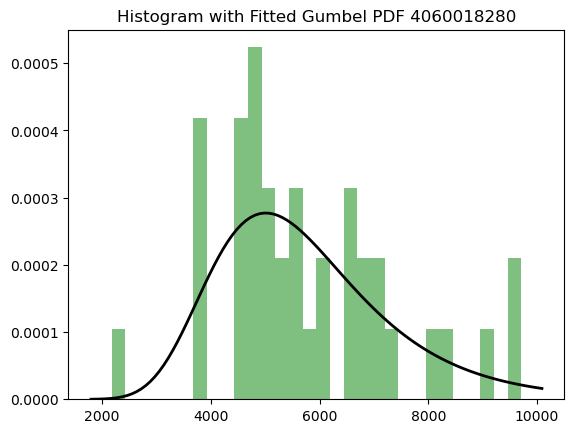

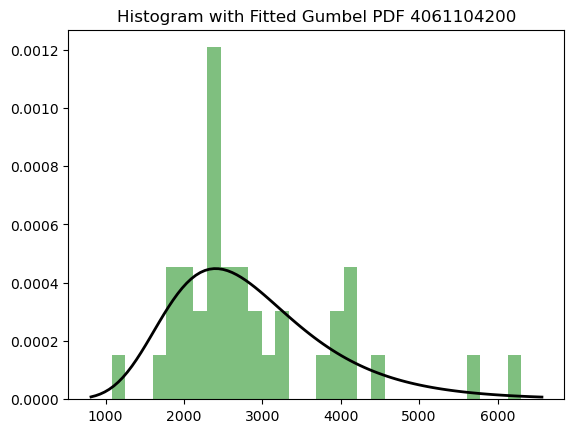

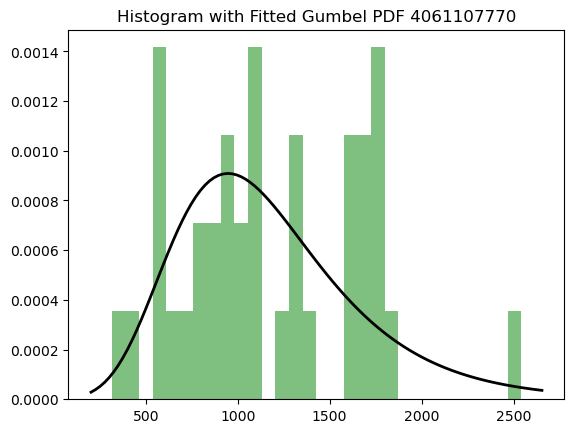

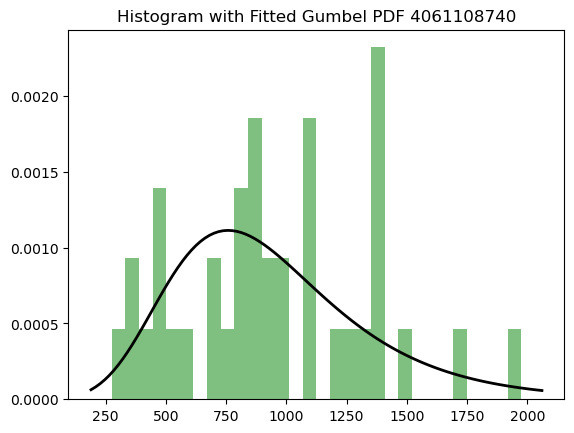

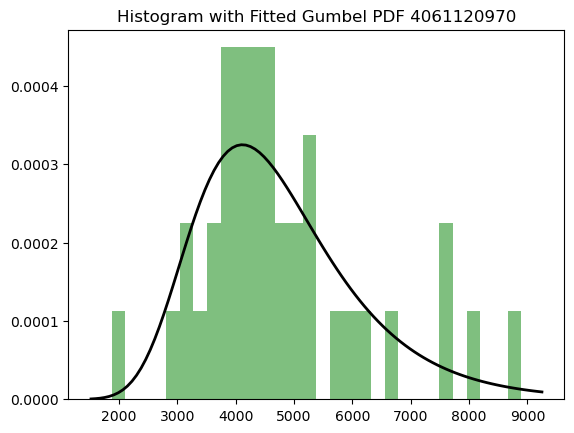

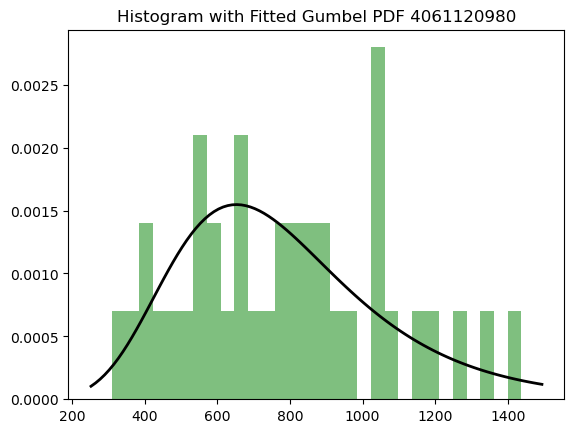

In [17]:
# check fit visually

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gumbel_r

for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()
    params = gumbel_params[basin_id]
    loc, scale = params['loc'], params['scale']
    # # Debug plot
    
    plt.hist(annual_maxima, bins=30, density=True, alpha=0.5, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = gumbel_r.pdf(x, loc, scale)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title("Histogram with Fitted Gumbel PDF %s" % basin_id)
    plt.show()

### Step 5: Transform data to Uniform Marginals

In [18]:
# Will do this using the CDF of the fitted Gumbel distribution 

# Dictionary to story uniform marginals for each basin
uniform_marginals = {}

for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()
    params = gumbel_params[basin_id]
    uniform_marginals[basin_id] = gumbel_r.cdf(annual_maxima, loc=params['loc'], scale=params['scale'])

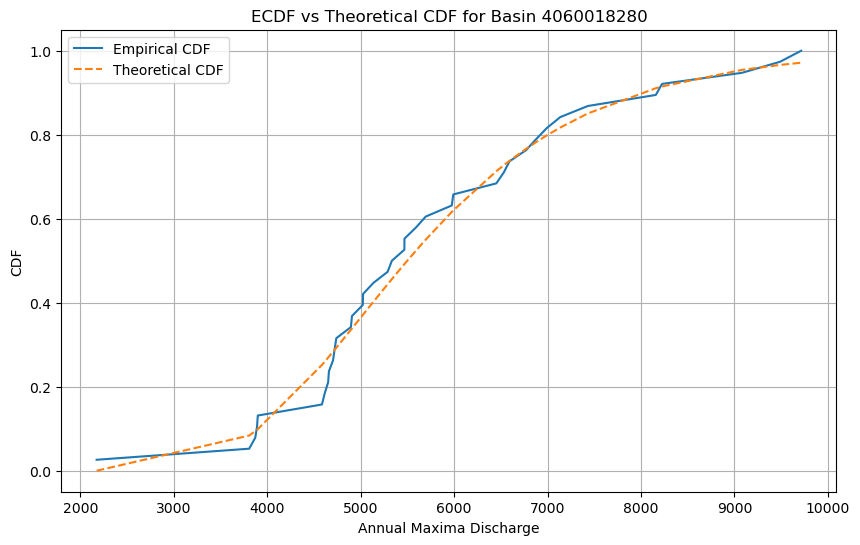

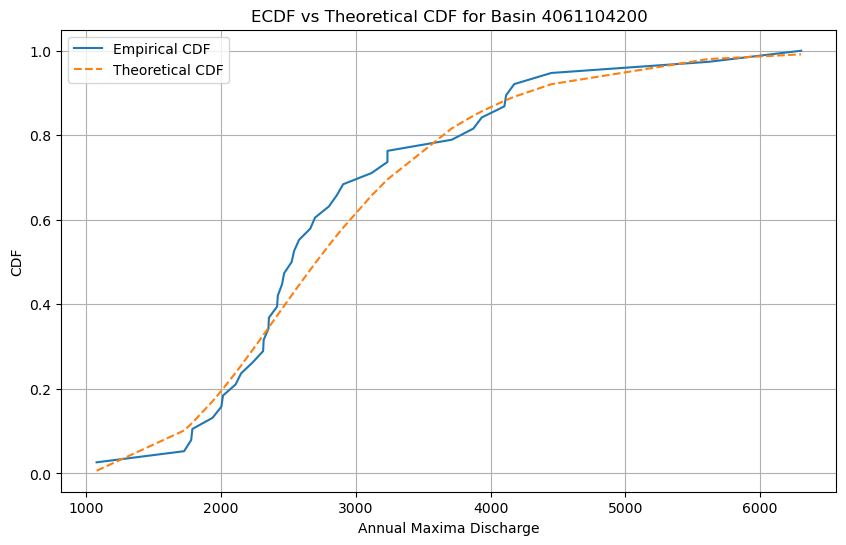

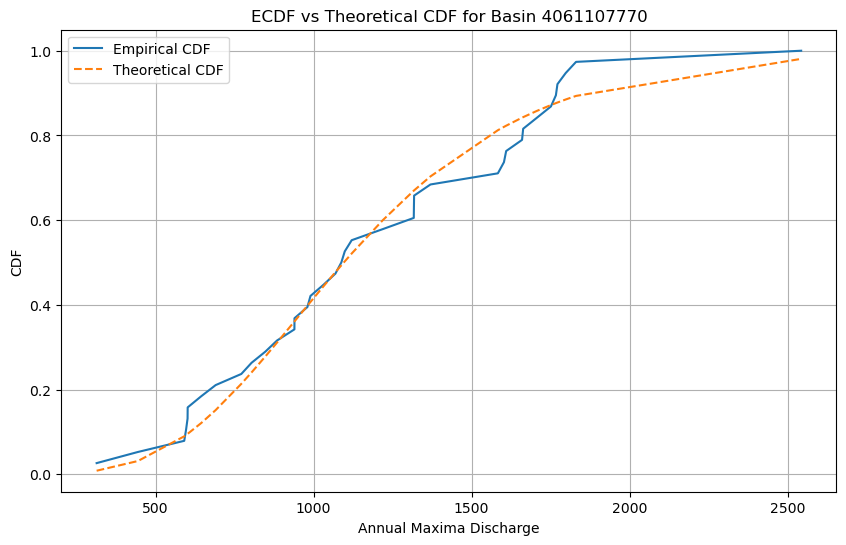

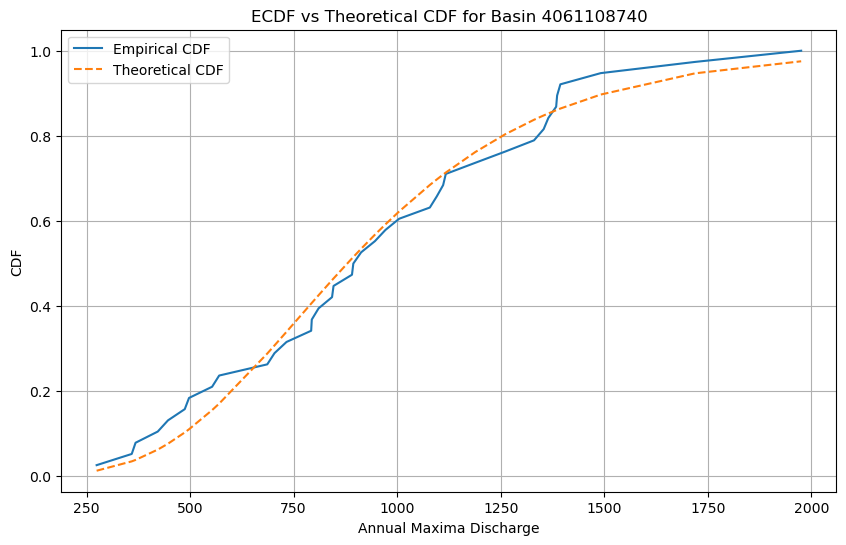

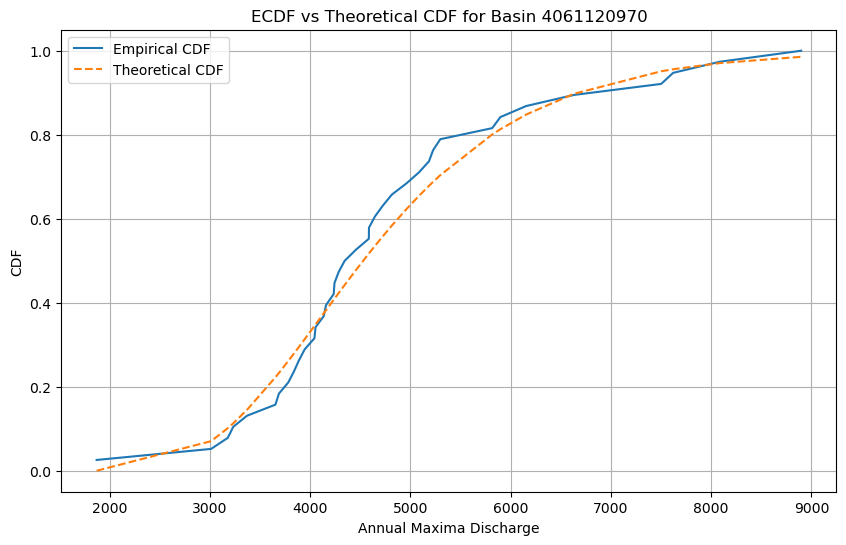

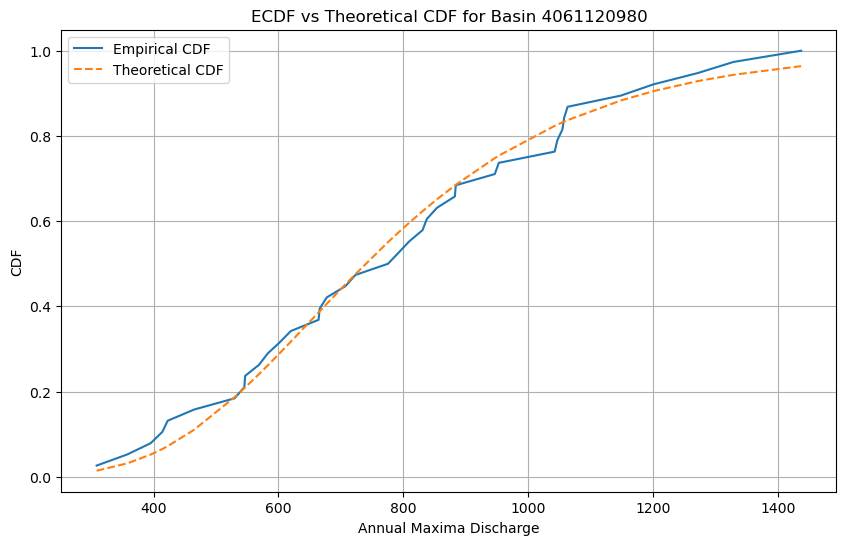

In [19]:
# check fit visually

for basin_id, timeseries in basin_timeseries.items():
    annual_maxima = timeseries.groupby(timeseries.index.year).max()
    params = gumbel_params[basin_id]
    # Sort data for empirical CDF plot
    sorted_maxima = np.sort(annual_maxima)
    empirical_cdf = np.arange(1, len(sorted_maxima)+1) / len(sorted_maxima)
    
    # Theoretical CDF
    theoretical_cdf = gumbel_r.cdf(sorted_maxima, loc=params['loc'], scale=params['scale'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_maxima, empirical_cdf, label='Empirical CDF')
    plt.plot(sorted_maxima, theoretical_cdf, label='Theoretical CDF', linestyle='--')
    plt.title(f'ECDF vs Theoretical CDF for Basin {basin_id}')
    plt.xlabel('Annual Maxima Discharge')
    plt.ylabel('CDF')
    plt.legend()
    plt.grid(True)
    plt.show()

### Step 6: Calculate pairwise dependence using the inverse Clayton copula

In [20]:
# Import necessary libraries
# NOTE: need to change virual environment to copulas here (issue with dependencies for sovereign-risk env)
from copulas.bivariate import Clayton

In [21]:
# Dictionary to store copula models for each pair of basins
clayton_copula_models = {}
clayton_error_basins = [] # list to store basins that cause an error

for id1, margins1 in uniform_marginals.items():
    for id2, margins2 in uniform_marginals.items():
        if id1 < id2: # to avoid duplicate pairs
            try:
                # Prepare the data for copula
                data = np.column_stack((1-margins1, 1-margins2)) # interested in upper tail dependence so take inverse of CDF
                
                # Fit the Clayton copula
                flipped_clayton = Clayton()
                flipped_clayton.fit(data)
    
                # Store the copula model
                clayton_copula_models[(id1, id2)] = flipped_clayton
            except ValueError as e:
                # print(f"Error fitting Clayton copula for basins {id1} and {id2}: {e}")
                clayton_error_basins.append((id1, id2))

In [22]:
# Store these copula pairs in a matrix

basin_ids = list(uniform_marginals.keys()) # take the basin IDs from the uniform marginals dictionary
N = len(basin_ids)


# Initialize the matrix with NaNs
dependence_matrix = np.full((N, N), np.nan)

# Map from basin ID to matrix index
id_to_index = {basin_id: index for index, basin_id in enumerate(basin_ids)}

for (id1, id2), copula_model in clayton_copula_models.items():
    index1, index2 = id_to_index[id1], id_to_index[id2]
    dependence_matrix[index1, index2] = copula_model.theta
    dependence_matrix[index2, index1] = copula_model.theta

# For error basins do the same but set theta to -1
for (id1, id2) in clayton_error_basins:
    index1, index2 = id_to_index[id1], id_to_index[id2]
    dependence_matrix[index1, index2] = -1
    dependence_matrix[index2, index1] = -1

# Debug (for infinity values) - not sure if needed but there are a few where I had to reassign basin outlets.
dependence_matrix[np.isinf(dependence_matrix)] = 1000

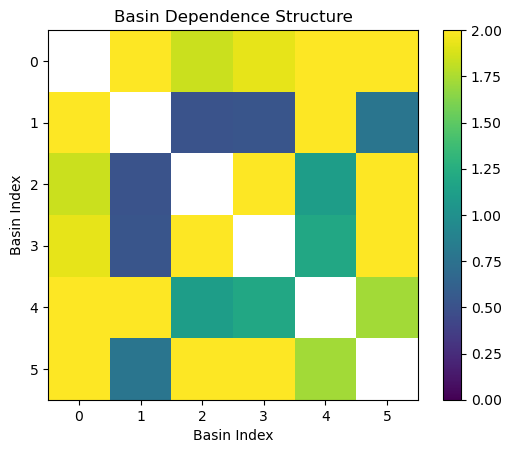

In [23]:
import matplotlib.pyplot as plt

plt.imshow(dependence_matrix, cmap='viridis', interpolation='none', vmin=0, vmax=2)
plt.colorbar()
plt.title('Basin Dependence Structure')
plt.xlabel('Basin Index')
plt.ylabel('Basin Index')
plt.show()

### Step 7: Ordered Coupling for Aggregation

##### Following the minimax structuring approach described in the Timonina et al (2015) paper

In [24]:
# Step 1: Find the most dependent pair
# Initialize a set to keep track of selected basin indices
selected_indices = set()
# convert dependence_matrix to a masked array, so that NaN values and -1 are not considered in the operation
masked_dependence_matrix = np.ma.masked_less(dependence_matrix, 0) # masking out values < 0
np.fill_diagonal(masked_dependence_matrix, np.ma.masked) # we want to ignore diagonal (NaN values)
max_theta_index = np.unravel_index(np.argmax(masked_dependence_matrix, axis=None), masked_dependence_matrix.shape)
ordered_basins = [basin_ids[max_theta_index[0]], basin_ids[max_theta_index[1]]]
# Add indices to the set of selected indices
selected_indices.update([max_theta_index[0], max_theta_index[1]])
# Step 2-4: Loop until all basins are ordered
while len(ordered_basins) < len(basin_ids):
    # Step 2: Choose basin k that is dependent on both basin i, j (last two basins in ordered_basins). Minimax approach
    # Exclude already selected basins from the selection process
    potential_next_indices = [i for i in range(len(basin_ids)) if i not in selected_indices]
    # Find the indices of the last two basins in ordered_basins
    last_two_indices = [id_to_index[basin] for basin in ordered_basins[-2:]]
    # Find dependency vectors for the last two basins
    dependency_vectors = masked_dependence_matrix[last_two_indices, :]
    # Calculate the minimum dependency for each row of the vector
    min_deps = np.ma.min(dependency_vectors, axis=0)
    # Mask already selected indices
    min_deps_masked = np.ma.copy(min_deps)
    # Debug 
    # Ensure min_deps_masked.mask is an array
    if np.isscalar(min_deps_masked.mask):
        min_deps_masked.mask = np.zeros(min_deps_masked.shape, dtype=bool)
    for idx in selected_indices:
        min_deps_masked.mask[idx] = True # mask the index if it's already in selected indices
    # Step 3: Find the maximum dependency value over the minimized vector - which will be the next basin
    next_basin_index = np.ma.argmax(min_deps_masked, fill_value=-np.inf)
    # Step 4: Continue iterations until there are no more basins left to process
    # Check if all options are effectively masked
    if min_deps_masked.mask.all():
        print("No suitable next basin found. Ending process.")
        break
    next_basin = basin_ids[next_basin_index]
    ordered_basins.append(next_basin)
    selected_indices.add(next_basin_index)

### Step 8: Aggregate through Hierarchical Monte-Carlo Sampling

In [25]:
def generate_conditional_sample(v, theta, r):
    '''
    Generate a conditional sample using the Flipped Calyton copula.
    Equation 12 from the Timonina et al (2015) paper

    :param v: Known loss in basin i
    :param theta: Copula parameter for dependency between basins i and j.
    :param r: Random value from uniform distribution for sampling.
    :retrun: Generated conditional loss in basin j.
    '''
    u = 1-(1+((1-v)**(-theta))*(((r**(-((theta)/(1+theta))))-1)))**(-(1/theta))
    return u 

In [26]:
# Function for extracting loss-probability curve for basin
def basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, rps):
    losses = [] # initialize empty list to store losses
    basin_df = loss_df[(loss_df[basin_col]==basin_id) & (loss_df['epoch']==epoch_val) & (loss_df['adaptation_scenario']==scenario_val)]
    grouped_basin_df = basin_df.groupby([basin_col, 'RP']).agg({'damages':'sum'}).reset_index()
    for i in rps:
        losses.append(grouped_basin_df.loc[grouped_basin_df['RP'] == i, 'damages'].sum())
    # Return losses (index indicates what the RP is)
    return losses

In [27]:
def interpolate_damages(RPs, losses, sim_aep):
    aeps = [1/i for i in RPs]
    # Ensure AEPs are in ascending order for np.interp
    aeps.sort() 
    losses = losses[::-1]

    # # test
    # sim_aep = 1 - sim_aep # convert extreme simulated AEPs (e.g. 0.95) to equivalent AEPs for interpolation (e.g. 0.05)

    # Interpolate based off simulated AEP
    if sim_aep >= 0.5: 
        return 0 
    else:
        interpolated_value = np.interp(sim_aep, aeps, losses)
        return interpolated_value

In [28]:
def get_copula_model(copula_models, basin1, basin2):
    """
    Attempt to retrieve a copula model for a given pair of basins.
    Tries both possible orders of the basin IDs.

    :param copula_models: Dictionary of copula models.
    :param basin1: ID of the first basin.
    :param basin2: ID of the second basin.
    :return: The copula model if found, else None.
    """
    return copula_models.get((basin1, basin2)) or copula_models.get((basin2, basin1))

In [29]:
# Show figure of distribution
def distribution_figure(theta, r, loss, current_loss):
    r_samples = np.random.uniform(0, 1, 1000)
    plt.figure(figsize=(5, 4))
    u_samples = [generate_conditional_sample(loss, theta, r_s) for r_s in r_samples]
    new_loss = generate_conditional_sample(loss, theta, r)
    plt.hist(u_samples, bins=50, alpha=0.5, label=f'Theta={theta}')
    plt.xlabel('Conditional Loss u')
    plt.ylabel('Frequency')
    plt.title('r: %s Previous Loss: %s Current Loss: %s' % (r, loss, current_loss))
    plt.legend()
    plt.show()

In [41]:
# Function for Monte Carlo simulating incorporating basin dependencies
def monte_carlo_dependence_simulation(loss_df, rps, basin_col, epoch_val, scenario_val, num_years, ordered_basins, copula_models, gumbel_params, num_simulations=10000):
    '''
    Perform Monte Carlo simulations of yearly losses incorporating basin dependencies.

    :param loss_df: dataframe with losses from risk analysis
    :param rps: list of return periods to consider. 
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param epoch_val: name of epoch value (e.g. 'Today')
    :param scenario_val: name of scenario (e.g. 'Baseline')
    :param num_years: Number of years to simulate
    :param ordered_basins: List of basin IDs ordered by dependency
    :param copula_models: Dictionary holding copula model for each basin pair
    :param gumbel_params: Gumbel distribution parameters for each basin.
    :param num__simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year.
    '''

    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin
    basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, rps) for basin_id in ordered_basins}
    # Initialize arrat for national losses
    national_losses_per_year = np.zeros((num_simulations, num_years))
    # Generate all random numbers in advance
    random_numbers = np.random.uniform(0, 1, (num_simulations, num_years, len(ordered_basins))).astype(np.float32)

    for simulation in range(num_simulations):
        # print progress
        if simulation % 50 == 0:
            print('Simulation progress: %s out of %s' % (simulation, num_simulations))
        for year in range(num_years):
            # Initialize a list to store losses for each basin for the current year
            yearly_losses = []
            yearly_loss_values = []
            for i, basin_id in enumerate(ordered_basins):
                if i == 0:
                    # Handle first basin
                    r = random_numbers[simulation, year, i]
                    loss_curve = basin_loss_curves[basin_id]
                    yearly_losses.append(r) # will store losses as AEP
                    yearly_loss_values.append(interpolate_damages(rps, loss_curve, r)) # store losses as interpolated values
                else:
                    loss_curve = basin_loss_curves[basin_id]
                    # Handle subsequent basins with dependencies
                    copula = get_copula_model(copula_models, ordered_basins[i-1], basin_id)
                    if copula is not None:
                        # Apply dependency model if theta exists
                        r = random_numbers[simulation, year, i]
                        previous_loss = yearly_losses[i-1]
                        current_loss = generate_conditional_sample(previous_loss, copula.theta, r)
                        # print(copula.theta, previous_loss, r, current_loss)
                        yearly_losses.append(current_loss)
                        yearly_loss_values.append(interpolate_damages(rps, loss_curve, (1-current_loss))) # here we are inverting the random number to AEP to simulate tail dependence
                        # yearly_loss_values.append(interpolate_damages(rps, loss_curve, current_loss)) # test
                        # print('actual loss:', interpolate_damages(rps, loss_curve, (1-current_loss)))
                        # distribution_figure(copula.theta, r, previous_loss, (current_loss))
                    else:
                        # Independent simulation for this basin
                        r = random_numbers[simulation, year, i]
                        yearly_losses.append(r)
                        yearly_loss_values.append(interpolate_damages(rps, loss_curve, r))

            # Aggregate losses for the current year
            national_losses_per_year[simulation, year] = sum(yearly_loss_values)

    # Convert the results into a DataFrame
    return pd.DataFrame(national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

In [42]:
### I THINK WHAT I NEED TO DO IS CALCULATE THE RESULTANT DISCHARGE CORRELATION. 

In [43]:
loss_data = pd.read_csv(r"D:\projects\sovereign-risk\Thailand\data\flood\dependence\thailand-basins\test\trouble_shoot\risk_basin_simplified_test_6.csv")
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
simulated_losses = monte_carlo_dependence_simulation(loss_data, rps, 'HB_L6', 'Today', 'Baseline', 1000, ordered_basins, clayton_copula_models, gumbel_params, 500)

Simulation progress: 0 out of 500
Simulation progress: 50 out of 500
Simulation progress: 100 out of 500
Simulation progress: 150 out of 500
Simulation progress: 200 out of 500
Simulation progress: 250 out of 500
Simulation progress: 300 out of 500
Simulation progress: 350 out of 500
Simulation progress: 400 out of 500
Simulation progress: 450 out of 500


In [44]:
test_losses = monte_carlo_dependence_simulation(loss_data, rps, 'HB_L6', 'Today', 'Baseline', 1, ordered_basins, clayton_copula_models, gumbel_params, 1)

Simulation progress: 0 out of 1


In [45]:
# Independent and dependent loss functions
def simulate_independent_losses(loss_df, rps, num_years, ordered_basins, num_simulations=10000):
    basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, 'HB_L6', 'Today', 'Baseline', rps) for basin_id in ordered_basins}
    national_losses_per_year = np.zeros((num_simulations, num_years))
    
    for simulation in range(num_simulations):
        for year in range(num_years):
            yearly_loss_values = [interpolate_damages(rps, basin_loss_curves[basin_id], np.random.uniform(0, 1)) for basin_id in ordered_basins]
            national_losses_per_year[simulation, year] = sum(yearly_loss_values)
    
    return national_losses_per_year.flatten()  # Flatten to create a single array of all losses
def simulate_completely_dependent_losses(loss_df, rps, num_years, ordered_basins, num_simulations=10000):
    basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, 'HB_L6', 'Today', 'Baseline', rps) for basin_id in ordered_basins}
    # # Arbitrarily use the first basin's loss curve as the basis for dependence
    # first_basin_loss_curve = basin_loss_curve(loss_df, ordered_basins[0], 'HB_L6', 'Today', 'Baseline', rps)
    national_losses_per_year = np.zeros((num_simulations, num_years))
    
    for simulation in range(num_simulations):
        for year in range(num_years):
            # Simulate one loss and apply it across all basins
            r = np.random.uniform(0, 1)
            yearly_loss_values = [interpolate_damages(rps, basin_loss_curves[basin_id], r) for basin_id in ordered_basins]
            national_losses_per_year[simulation, year] = sum(yearly_loss_values)
    
    return national_losses_per_year.flatten()  # Flatten to create a single array of all losses

In [46]:
independent_losses = simulate_independent_losses(loss_data, rps, 1000, ordered_basins, num_simulations=500)
dependent_losses = simulate_completely_dependent_losses(loss_data, rps, 1000, ordered_basins, num_simulations=500)

In [47]:
# Plot loss-probability curve
all_losses =simulated_losses.values.flatten()  # Flatten to get a single array of losses
sorted_losses = np.sort(all_losses)[::-1]  # Sort losses from highest to lowest
aeps = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)  # Calculate AEPs

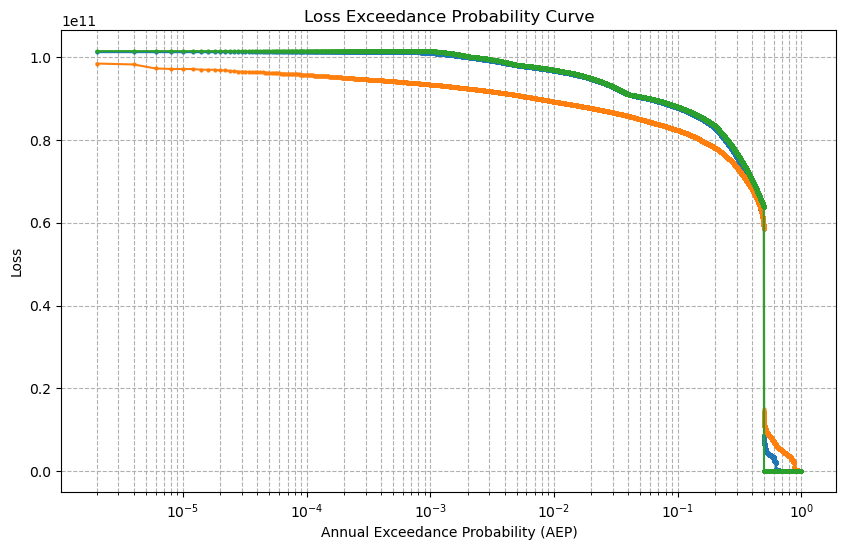

In [48]:
plt.figure(figsize=(10, 6))
plt.semilogx(aeps, sorted_losses, marker='o', linestyle='-', markersize=2)
plt.semilogx(aeps, np.sort(independent_losses)[::-1], marker='o', linestyle='-', markersize=2)
plt.semilogx(aeps, np.sort(dependent_losses)[::-1], marker='o', linestyle='-', markersize=2)
plt.xlabel('Annual Exceedance Probability (AEP)')
plt.ylabel('Loss')
plt.title('Loss Exceedance Probability Curve')
plt.grid(True, which="both", ls="--")
plt.show()


In [49]:
# # Other approach for dependent losses
# def get_losses_for_rps(loss_df, basin_col, epoch_val, scenario_val, rps, ordered_basins):
#     """
#     Calculate the losses for each basin for specific return periods.
#     """
#     losses_for_rps = {}
#     for basin_id in ordered_basins:
#         loss_curve = basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, rps)
#         losses_for_rps[basin_id] = loss_curve
#     return losses_for_rps
# def aggregate_losses_nationally(losses_for_rps, rps, ordered_basins):
#     """
#     Aggregate the losses for each return period across all basins.
#     """
#     national_losses = {}
#     for rp in rps:
#         total_loss = sum(losses_for_rps[basin_id][rp] for basin_id in ordered_basins)
#         national_losses[rp] = total_loss
#     return national_losses
# def prepare_data_for_plotting(national_losses):
#     """
#     Prepare the national loss data for plotting.
#     """
#     aeps = [1/rp for rp in national_losses.keys()]
#     losses = list(national_losses.values())
#     return aeps, losses
# losses_for_rps = get_losses_for_rps(loss_df, 'HB_L6', 'Today', 'Baseline', rps, ordered_basins)
# national_losses = aggregate_losses_nationally(losses_for_rps, rps, ordered_basins)
# dep_aeps, dep_losses = prepare_data_for_plotting(national_losses)

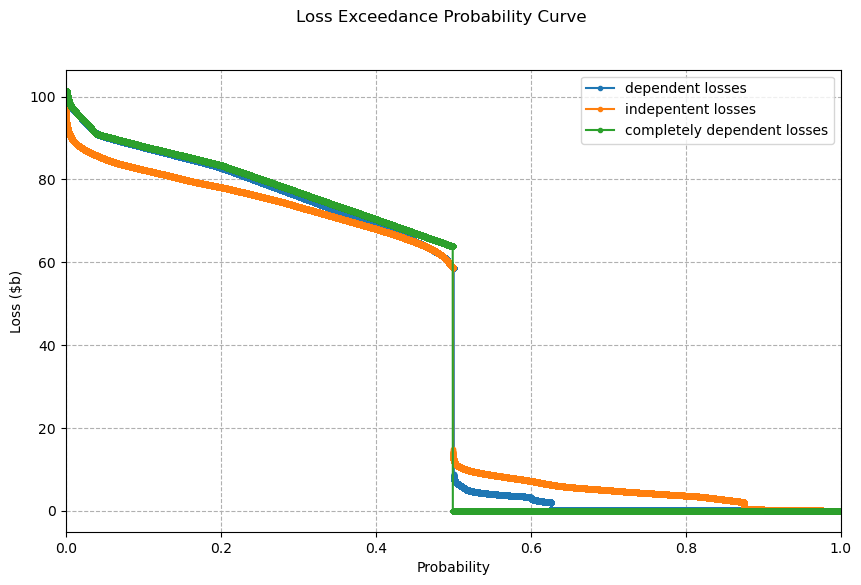

In [50]:
theta_losses_b = sorted_losses/1000000000
independent_losses_b = np.sort(independent_losses/1000000000)[::-1]
dependent_losses_b = np.sort(dependent_losses/1000000000)[::-1]

plt.figure(figsize=(10, 6))
plt.plot(aeps, theta_losses_b, marker='.', linestyle='-', label='dependent losses')
plt.plot(aeps, independent_losses_b, marker='.', linestyle='-', label='indepentent losses')
plt.plot(aeps, dependent_losses_b, marker='.', linestyle='-', label='completely dependent losses')
# plt.xscale('log')
plt.ylabel('Loss ($b)')
plt.xlabel('Probability')
plt.xlim(0, 1)
plt.suptitle('Loss Exceedance Probability Curve')
plt.legend()
plt.grid(True, which='both', ls='--')

In [262]:
extracted_theta_values = {}
for (basin1, basin2), model in clayton_copula_models.items():
    extracted_theta_values[(basin1, basin2)] = model.theta  # Assuming the copula model has a .theta attribute

In [49]:
def get_loss_for_rp(aeps, losses, rp):
    target_aep = 1 / rp
    # Find the closest AEP in the array to the target AEP and get the corresponding loss
    idx = (np.abs(aeps - target_aep)).argmin()
    return losses[idx]

# Example: Get the 100-year RP loss
loss_100yr = get_loss_for_rp(aeps, sorted_losses, 100)
loss_10yr = get_loss_for_rp(aeps, sorted_losses, 10)
loss_2yr = get_loss_for_rp(aeps, sorted_losses, 2)
print(f"The 100-year RP dependent loss is: {loss_100yr}")
print(f"The 10-year RP dependent loss is: {loss_10yr}")
print(f"The 2-year RP dependent loss is: {loss_2yr}")
loss_100yr = get_loss_for_rp(aeps, np.sort(independent_losses)[::-1], 100)
loss_10yr = get_loss_for_rp(aeps, np.sort(independent_losses)[::-1], 10)
loss_2yr = get_loss_for_rp(aeps, np.sort(independent_losses)[::-1], 2)
print(f"The 100-year RP independent loss is: {loss_100yr}")
print(f"The 10-year RP independent loss is: {loss_10yr}")
print(f"The 2-year RP independent loss is: {loss_2yr}")
loss_100yr = get_loss_for_rp(aeps, np.sort(dependent_losses)[::-1], 100)
loss_10yr = get_loss_for_rp(aeps, np.sort(dependent_losses)[::-1], 10)
loss_2yr = get_loss_for_rp(aeps, np.sort(dependent_losses)[::-1], 2)
print(f"The 100-year RP complete dependence loss is: {loss_100yr}")
print(f"The 10-year RP complete dependence loss is: {loss_10yr}")
print(f"The 2-year RP complete dependence loss is: {loss_2yr}")

The 100-year RP dependent loss is: 96656588205.20383
The 10-year RP dependent loss is: 87726544325.6115
The 2-year RP dependent loss is: 7580976210.299881
The 100-year RP independent loss is: 89211039148.69882
The 10-year RP independent loss is: 82358976223.27756
The 2-year RP independent loss is: 58646484851.85516
The 100-year RP complete dependence loss is: 96998934365.86223
The 10-year RP complete dependence loss is: 88035600310.7117
The 2-year RP complete dependence loss is: 0.0


### AREA FOR DEBUGGING

0.9914195717771944
0.9926435429702202
0.9912155849905436
0.9899838641335531
0.989689237803717


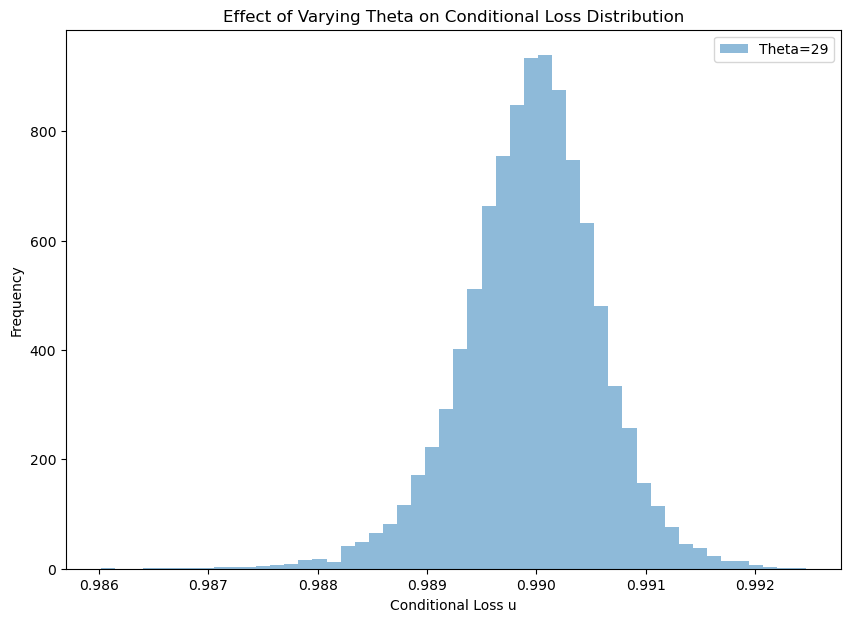

In [47]:
v = 0.99  # Fixed known loss in basin i
thetas = [29]  # Different values of theta to visualize
r_samples = np.random.uniform(0, 1, 10000)  # Generate 1000 random samples

plt.figure(figsize=(10, 7))

for theta in thetas:
    u_samples = [generate_conditional_sample(v, theta, r) for r in r_samples]
    plt.hist(u_samples, bins=50, alpha=0.5, label=f'Theta={theta}')

print(generate_conditional_sample(v, theta, 0.01))
print(generate_conditional_sample(v, theta, 0.0001))
print(generate_conditional_sample(v, theta, 0.02))
print(generate_conditional_sample(v, theta, 0.5))
print(generate_conditional_sample(v, theta, 0.7))

plt.title('Effect of Varying Theta on Conditional Loss Distribution')
plt.xlabel('Conditional Loss u')
plt.ylabel('Frequency')
plt.legend()
plt.show()

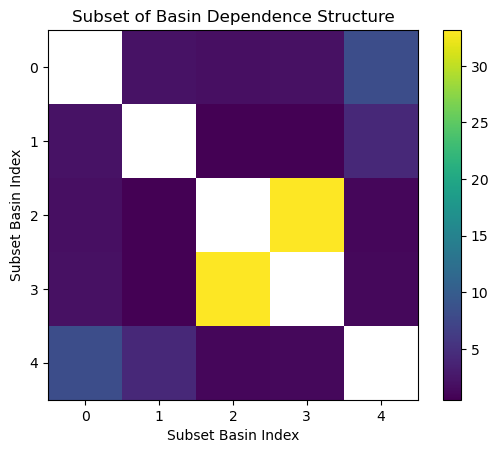

In [51]:
subset_matrix = dependence_matrix[0:5, 0:5]

plt.imshow(subset_matrix, cmap='viridis', interpolation='none')
plt.colorbar()
plt.title('Subset of Basin Dependence Structure')
plt.xlabel('Subset Basin Index')
plt.ylabel('Subset Basin Index')
plt.show()

In [76]:
# Convert matrix to dataframe
dependence_matrix_df = pd.DataFrame(dependence_matrix, index=basin_ids, columns=basin_ids)
# Export to cSV to inspect
dependence_matrix_df.to_csv('dependence_matrix.csv')